In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import interp1d
from scipy.optimize import root

In [17]:
common_settings = {
'omega_b':0.0223828,
'h':0.67810,
'z_reio':7.6711,
'YHe':0.25,
'perturbations_verbose':1,
'background_verbose':3,
'output':'mTk, vTk, mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':10,
'z_max_pk':1000,
'format':'class',

'omega_cdm':0.11,

}

In [30]:
chiCDM = Class()
# pass input parameters
chiCDM.set(common_settings)
aNR=1.e-3
f_chi=0.1
print(f'aNR={aNR},zNR={1/aNR -1}')
chiCDM.set({
'N_ur': 3.046,
'f_chi':0.001,
'acs_chi':aNR,
'cs2_peak_chi':1./3.,
# 'T_cmb':1.8,
})
chiCDM.compute()

#get the growth factor of a LCDM equivalent
pureCDM = Class()
pureCDM.set(common_settings)
pureCDM.set({
    'N_ur': 3.046,
    'f_chi':1.e-6,
    # 'omega_cdm':0.4363+0.00107363,
    # 'f_chi': 1.e-8,
})
pureCDM.compute()

f_CDM=interp1d(1/(1+pureCDM.get_background()['z']),pureCDM.get_background()['gr.fac. f'])
Ha_pure=pureCDM.get_background()['H [1/Mpc]']/(1.+pureCDM.get_background()['z'])
Ha_pure_int=interp1d(1/(1.+pureCDM.get_background()['z']),Ha_pure)

aNR=0.001,zNR=999.0
Running CLASS version v3.2.0
Computing background
Chose ndf15 as generic_evolver
 -> age = 14.052301 Gyr
 -> conformal age = 14562.939085 Mpc
 -> N_eff = 3.046 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3166.412035
    corresponding to conformal time = 121.224303 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.239224        , omega = 0.11           
-> Dark Matter with sound speed:  Omega = 0.00028819      , omega = 0.000132515    
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic relics      Omega = 3.72044e-05     , omega = 1.71073e-05    
 ---> Other Content 
-> Cosmological Constant          Omega = 0.711719        , omega = 0.327262   

0.012041925263103874


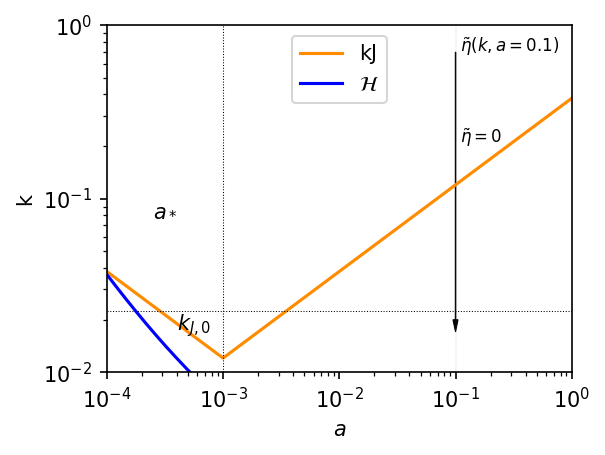

In [31]:
plt.figure(figsize=(4,3), dpi=150)

background = chiCDM.get_background() # load background table
a = 1/(background['z']+1) # read redshift
rho_cdm=background['(.)rho_cdm']
rho_chi=background['(.)rho_chi']
kJ_chi=background['(.)kJ_chi']

Ha=background['H [1/Mpc]']/(1.+background['z'])
Ha_chi_int=interp1d(a,Ha)

kJ_int=interp1d(a,kJ_chi)

plt.xlabel(r'$a $')

h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc

# plt.loglog(background_a,cFS2_nu,label=r'cFS')
plt.loglog(a,kJ_chi,'darkorange',label=r'kJ')

plt.loglog(a,Ha/h,'blue',label=r'$\mathcal{H}$')

plt.axhline(y=0.02243141372267004, color='k', linewidth=0.5, linestyle = ':')
plt.axvline(x=aNR, color='k', linewidth=0.5, linestyle = ':')
plt.axvline(x=0.1, color='gray', linewidth=0.1, linestyle = '--')

plt.text(0.1, 0.45, r'$a_*$', transform=plt.gca().transAxes)
plt.text(0.15, 0.12, r'$k_{J,0}$', transform=plt.gca().transAxes)
plt.text(0.11, 0.7, r'$\tilde \eta (k,a=0.1)$', fontsize=8)
plt.text(0.11, 0.21, r'$\tilde \eta = 0$', fontsize=8)

plt.arrow(0.1, 0.7, 0, -0.68, head_width=0.01, head_length=0.003, fc='k', ec='k', linewidth=0.5)


plt.xlim([1.e-4,1])
plt.ylim([1.e-2,1])

plt.legend(loc='upper center')
plt.xscale('log')
plt.xlabel(r'$a$')
plt.ylabel(r'k')
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/kscales-for-g.pdf',bbox_inches='tight')
print(kJ_int(aNR))
plt.show()


In [3]:
np.log10(2.78e-04)

-3.555955204081924

----
as a function of k

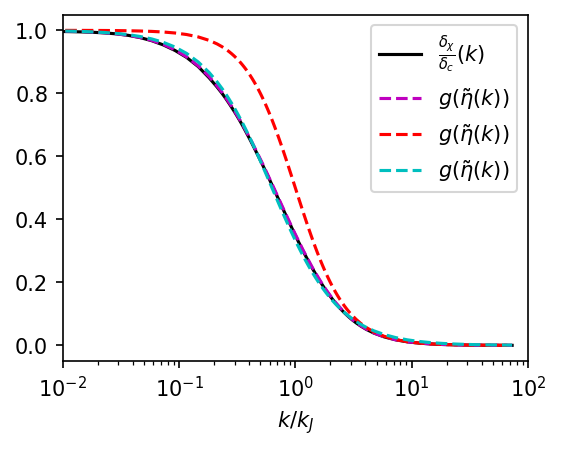

In [34]:
zeval = 2
chi_tk_k = chiCDM.get_transfer(z=zeval)

kEval=chi_tk_k['k (h/Mpc)']

d_chi_k=-chi_tk_k['d_chi']
d_cdm_k=-chi_tk_k['d_cdm']

T_ratio_k =d_chi_k/ d_cdm_k

from scipy.integrate import odeint

## START WITH g AND h 
def gh_system(w, t):
    g,h = w
    dgdt = h - g
    dhdt = 3/2 *(1-h)-3/2*np.exp(-t)*g
    return [dgdt, dhdt]
w0 = [0.,0.]
t = np.linspace(-10,30, 100)  #t is tilde eta
sol = odeint(gh_system, w0, t)

k_of_t = kJ_int(aNR)* np.sqrt(0.1/aNR) * np.exp(-0.5*t)

kJeval=kJ_int(1/(zeval+1))

g_int_k = interp1d(k_of_t, sol[:, 0], fill_value='extrapolate')
g_int_t = interp1d(t, sol[:, 0], fill_value='extrapolate')

plt.figure(figsize=(4,3), dpi=150)
plt.plot(kEval/kJeval, T_ratio_k,'k',label=r'$\frac{\delta_\chi}{\delta_c}(k)$')

# plt.plot(kEval/kJeval, g_int_k(kEval),'green',label=r'$g(\tilde \eta (k))$')
plt.plot(kEval/kJeval, g_int_t(-2*np.log(kEval/kJeval)),'m--',label=r'$g(\tilde \eta (k))$')
plt.plot(kEval/kJeval, 1/(1+(kEval/kJeval)**2),'r--',label=r'$g(\tilde \eta (k))$')
plt.plot(kEval/kJeval, 1/(1+2*(kEval/kJeval)**1.5),'c--',label=r'$g(\tilde \eta (k))$')


plt.xscale('log')
plt.xlabel(r'$k/k_J$')
plt.legend()
plt.xlim([1.e-2,1.e2])
# plt.text(0.45, 0.15, r'$f_\chi = 10\%, \; z=9$', transform=plt.gca().transAxes)

# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/g_of_k_ansol.pdf')
plt.show()

----
as a function of a

In [125]:
a_eval=np.logspace(-2.5,0,100)
chi_tk_z=[]
for a in a_eval:
    chi_tk_z.append(chiCDM.get_transfer(z=1/a-1))
chi_tk_z=np.array(chi_tk_z)

kidx=70
kEval=chi_tk_z[1]['k (h/Mpc)'][kidx]
print('Evaluating at k={:.6f}'.format(kEval))# print(tk['d_chi'].shape)

d_chi_z=-np.array([d['d_chi'][kidx] for d in chi_tk_z])
d_cdm_chi_z=-np.array([d['d_cdm'][kidx] for d in chi_tk_z])

g_ratio =d_chi_z/ d_cdm_chi_z

Evaluating at k=0.260516


eta star = -6.907755278982137
logratio = 4.904404930937937
kJ* = 0.02243141372267004
[0.13445735]


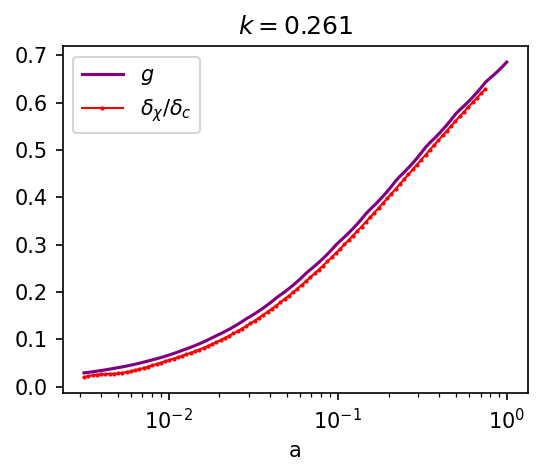

In [126]:
from scipy.integrate import odeint

## START WITH g AND h 
def gh_system(w, t):
    g,h = w
    dgdt = h - g
    dhdt = 3/2 *(1-h)-3/2*np.exp(-t)*g
    return [dgdt, dhdt]
# Initial conditions
w0 = [0.,0.]
t = np.linspace(-10,30, 100)
sol = odeint(gh_system, w0, t)

D_cdm=d_cdm_pure_z/d_cdm_pure_z[-1]
a_D_cdm=interp1d(d_cdm_pure_z/d_cdm_pure_z[-1],a_eval)

# Plot the solution
eta_star=np.log(aNR)
print(f'eta star = {eta_star}')
print(f'logratio = {2*np.log(kEval/kJ_int(aNR))}')
print(f'kJ* = {kJ_int(aNR)}')
eta=t+eta_star+2*np.log(kEval/kJ_int(aNR))

#Other method
def etaJ_eq(x):
    return kJ_int(a_D_cdm(x)) - kEval
solution = root(etaJ_eq, 1.e-1)  # 1 is the initial guess
print(solution.x)  # This will print the solution
eta_J = np.log(solution.x[0])
eta=t+eta_J

#t is tilde eta, ci ho perso una giornata eh

g_int = interp1d(np.exp(eta), sol[:, 0])
h_int = interp1d(np.exp(eta), sol[:, 1])

plt.figure(figsize=(4,3), dpi=150)

plt.plot(a_eval, g_int(D_cdm),'purple',label=r'$g$')
plt.plot(a_eval[:-5],g_ratio[:-5],'r-o',label=r'$\delta_{\chi} / \delta_c$', markersize=1., linewidth=1.)
plt.title(r'$k='+'{:.3f}'.format(kEval)+r'$')
# plt.axhline(y=1, color='k', linewidth=0.7)
plt.xscale('log')
plt.xlabel('a')
plt.legend()
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/s_growth.pdf')
plt.show()

Evaluating at k=0.124302
[0.03153574]
Evaluating at k=0.504649
[0.50224274]


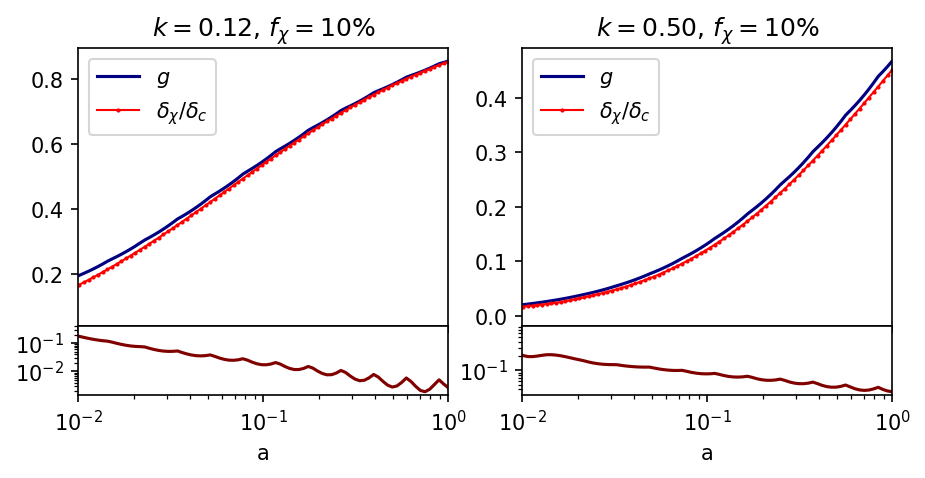

In [129]:
fig, axs = plt.subplots(2, 2, sharex=True,gridspec_kw={'height_ratios': [4,1]}, figsize=(7,3), dpi=150)
plt.subplots_adjust(hspace = 0)

# PLOT 1 ==========
kidx=48
kEval=chi_tk_z[1]['k (h/Mpc)'][kidx]
print('Evaluating at k={:.6f}'.format(kEval))# print(tk['d_chi'].shape)

d_chi_z=-np.array([d['d_chi'][kidx] for d in chi_tk_z])
d_cdm_chi_z=-np.array([d['d_cdm'][kidx] for d in chi_tk_z])

g_ratio =d_chi_z/ d_cdm_chi_z
def etaJ_eq(x):
    return kJ_int(a_D_cdm(x)) - kEval
solution = root(etaJ_eq, 1.e-1)  # 1 is the initial guess
print(solution.x)  # This will print the solution
eta_J = np.log(solution.x[0])
eta=t+eta_J

#t is tilde eta, ci ho perso una giornata eh

g_int = interp1d(np.exp(eta), sol[:, 0])

axs[0,0].plot(a_eval, g_int(D_cdm),'navy',label=r'$g$', markersize=2.)
axs[0,0].plot(a_eval,g_ratio,'r-o',label=r'$\delta_\chi / \delta_c$',markersize=1., linewidth=1.)

axs[1,0].loglog(a_eval,np.abs(g_int(D_cdm)/g_ratio-1), 'maroon', label='Rel diff')

axs[0,0].legend(loc='best')
axs[0,0].set_xlim([1.e-2,1])
axs[0,0].set_xscale('log')
axs[1,0].set_xlabel('a')
axs[0,0].set_title(r'$k='+'{:.2f}'.format(kEval)+r'$'+ r', $f_\chi=10\%$')

# PLOT 2 ==========
kidx=90
kEval=chi_tk_z[1]['k (h/Mpc)'][kidx]
print('Evaluating at k={:.6f}'.format(kEval))# print(tk['d_chi'].shape)

d_chi_z=-np.array([d['d_chi'][kidx] for d in chi_tk_z])
d_cdm_chi_z=-np.array([d['d_cdm'][kidx] for d in chi_tk_z])

g_ratio =d_chi_z/ d_cdm_chi_z
def etaJ_eq(x):
    return kJ_int(a_D_cdm(x)) - kEval
solution = root(etaJ_eq, 1.e-1)  # 1 is the initial guess
print(solution.x)  # This will print the solution
eta_J = np.log(solution.x[0])
eta=t+eta_J

#t is tilde eta, ci ho perso una giornata eh

g_int = interp1d(np.exp(eta), sol[:, 0])

axs[0,1].plot(a_eval, g_int(D_cdm),'navy',label=r'$g$', markersize=2.)
axs[0,1].plot(a_eval,g_ratio,'r-o',label=r'$\delta_\chi/ \delta_c$',markersize=1., linewidth=1.)
axs[1,1].loglog(a_eval,np.abs(g_int(D_cdm)/g_ratio-1), 'maroon', label='Rel diff')
axs[0,1].legend(loc='best')
axs[0,1].set_xlim([1.e-2,1])
axs[0,1].set_xscale('log')
axs[1,1].set_xlabel('a')
axs[0,1].set_title(r'$k='+'{:.2f}'.format(kEval)+r'$' + r', $f_\chi=10\%$')

# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/g_dTk_10perc.pdf',bbox_inches='tight')

plt.show()